# Twitter sentiment analysis using NLTK, TextBlob, VaderSentiment and Bert

Sentiment analysis (also known as opinion mining or emotion AI) is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.

To do our analysis we will use the Twitter API, which you can find at https://developer.twitter.com/en/docs/twitter-api, to pull the tweets we want to analyze. We will also use the tweepy library to make our requests to the website.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tweepy as tw
from datetime import date
from langdetect import detect
import config

It is better, for privacy and security concerns, to store the API keys in a separate file, which I called 'config.py', and then import the file.

In [2]:
# Authenticate using API keys found on your twitter developer account

client = tw.Client(config.bearer_token, config.consumer_key, config.consumer_secret, config.access_token, config.access_token_secret)
auth = tw.OAuth1UserHandler(config.consumer_key, config.consumer_secret, config.access_token, config.access_token_secret)
api = tw.API(auth)

### Get tweets

With the new version of the twitter API you can search just 100 recent tweets, but you can avoid this limit by using the Paginator method. We query the english tweets and then save them in a list of dictionaries, which we then transform in a dataframe using pandas. 

In [3]:
keyword = '#SP500 -is:retweet lang:en'
query = tw.Paginator(client.search_recent_tweets, query=keyword,
                              tweet_fields=['text', 'created_at'], max_results=100).flatten(limit=1000)
tweets = [{'Tweets':tweet.text, 'Timestamp':tweet.created_at.date()} for tweet in query]

In [4]:
df = pd.DataFrame.from_dict(tweets)
df.head()

,Tweets,Timestamp
0,Bittercoins to crash below 20K?!\n\n#Stocks #b...,2022-06-18
1,This will be a super cycle but the bears \n#SP...,2022-06-18
2,Best options fill prices &amp; avoid options f...,2022-06-18
3,"This weekend: Mini pump\n\nNext week: Dump, fi...",2022-06-18
4,"https://t.co/H1RWIfFwyI\n\nBack at it, lets ca...",2022-06-18


In [5]:
df.shape

(1000, 2)

### Preprocess

Now it is time to preprocess the tweets to transform the text into a more digestible form so that machine learning algorithms can perform better. To do this we can use NLTK and TextBlob.

In [6]:
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
import unidecode
import contractions

In [7]:
#nltk.download('stopwords')
#nltk.download('wordnet')
stop_words = stopwords.words('english')
custom_stopwords = ['RT']

We will perform a very simple preprocessing. We want to remove the stopwords (basically,  very common words such that they do not help much in our NLP tasks), remove special characters, expand contractions and then lemmatize.

In [8]:
def preprocess_tweets(tweet, custom_stopwords):
    preprocessed_tweet = tweet.replace('?', '').replace(',', '').replace('#', '').replace('$', '').replace('^', '').replace('&', '').replace(':', '').replace(';', '')
    preprocessed_tweet = unidecode.unidecode(preprocessed_tweet)
    preprocessed_tweet = contractions.fix(preprocessed_tweet)
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in stop_words)
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in custom_stopwords)
    preprocessed_tweet = " ".join(Word(word).lemmatize() for word in preprocessed_tweet.split())
    return preprocessed_tweet
    
df['Processed_Tweet'] = df['Tweets'].apply(lambda x: preprocess_tweets(x, custom_stopwords)) 
df.head()

,Tweets,Timestamp,Processed_Tweet
0,Bittercoins to crash below 20K?!\n\n#Stocks #b...,2022-06-18,Bittercoins crash 20K! Stocks bitcoin trading ...
1,This will be a super cycle but the bears \n#SP...,2022-06-18,This super cycle bear SP500 NQ DowJones BTC ht...
2,Best options fill prices &amp; avoid options f...,2022-06-18,Best option fill price amp avoid option fill p...
3,"This weekend: Mini pump\n\nNext week: Dump, fi...",2022-06-18,This weekend Mini pump Next week Dump find bot...
4,"https://t.co/H1RWIfFwyI\n\nBack at it, lets ca...",2022-06-18,https//t.co/H1RWIfFwyI Back let u catch Bitcoi...


### Calculate sentiment

Import also vaderSentiment to perform the sentiment analysis (It gives, in my opinion, slightly better results than TextBlob for this task).

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj= SentimentIntensityAnalyzer()

Compute the polarity with Vader and TextBlob and the subjectivity.

In [10]:
df['polarity_blob'] = df['Processed_Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['polarity_vader'] = df['Processed_Tweet'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
df['subjectivity'] = df['Processed_Tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [11]:
df.head()

,Tweets,Timestamp,Processed_Tweet,polarity_blob,polarity_vader,subjectivity
0,Bittercoins to crash below 20K?!\n\n#Stocks #b...,2022-06-18,Bittercoins crash 20K! Stocks bitcoin trading ...,0.000000,0.2003,0.000000
1,This will be a super cycle but the bears \n#SP...,2022-06-18,This super cycle bear SP500 NQ DowJones BTC ht...,0.333333,0.5994,0.666667
2,Best options fill prices &amp; avoid options f...,2022-06-18,Best option fill price amp avoid option fill p...,0.538095,0.6705,0.514286
3,"This weekend: Mini pump\n\nNext week: Dump, fi...",2022-06-18,This weekend Mini pump Next week Dump find bot...,0.083333,-0.7003,0.200000
4,"https://t.co/H1RWIfFwyI\n\nBack at it, lets ca...",2022-06-18,https//t.co/H1RWIfFwyI Back let u catch Bitcoi...,0.000000,0.0000,0.000000


### Visualize

We can now plot some graphs to see our results. You can immeditely perceive that TextBlob fails togive a score to many tweets.

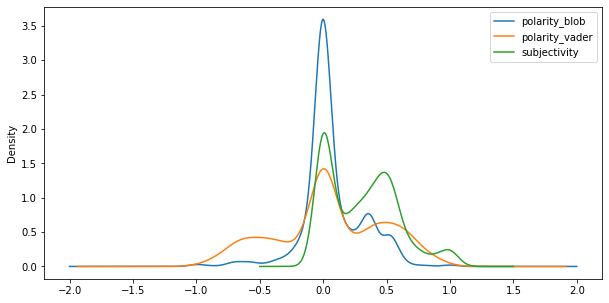

In [12]:
df.plot(figsize=(10,5), kind='density', legend=True);

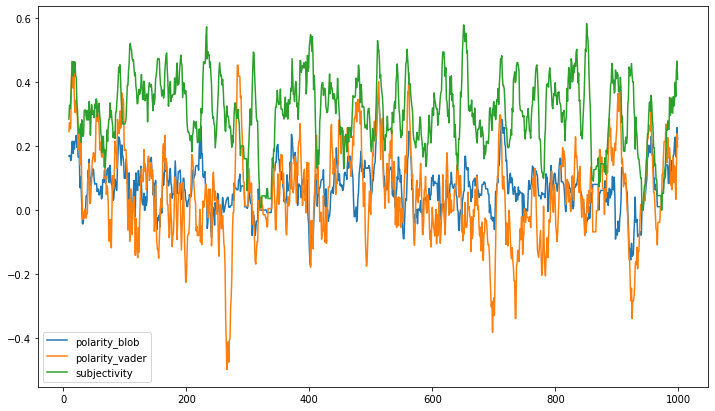

In [13]:
df.polarity_blob.rolling(10).mean().plot(legend=True, figsize=(12,7));
df.polarity_vader.rolling(10).mean().plot(legend=True, figsize=(12,7));
df.subjectivity.rolling(10).mean().plot(legend=True, figsize=(12,7));

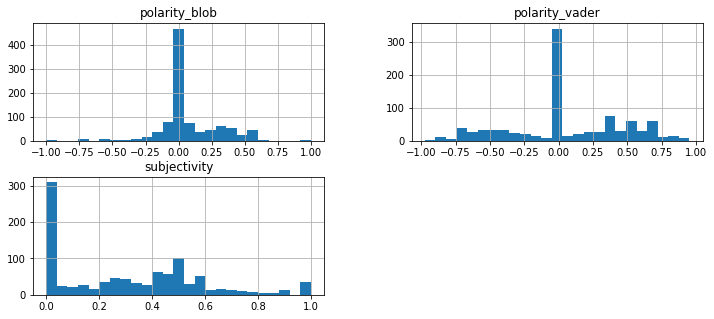

In [14]:
df.hist(bins=25, figsize=(12,5));

We can compute some statistics to better understand how the two NLP tools have performed. TextBlob missedd 100 more tweets than Vader.

In [15]:
df.describe()

,polarity_blob,polarity_vader,subjectivity
count,1000.000000,1000.000000,1000.000000
mean,0.070047,0.052417,0.308137
std,0.239378,0.422281,0.279236
min,-1.000000,-0.974300,0.000000
25%,0.000000,-0.202300,0.000000
50%,0.000000,0.000000,0.300000
75%,0.166667,0.401900,0.509643
max,1.000000,0.953100,1.000000


In [16]:
df[df.polarity_blob==0].count()

Tweets             420
Timestamp          420
Processed_Tweet    420
polarity_blob      420
polarity_vader     420
subjectivity       420
dtype: int64

In [17]:
df[df.polarity_vader==0].count()

Tweets             333
Timestamp          333
Processed_Tweet    333
polarity_blob      333
polarity_vader     333
subjectivity       333
dtype: int64

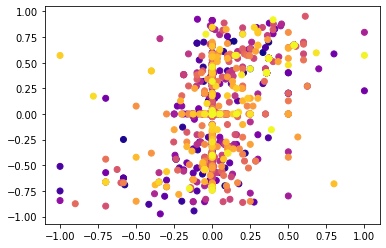

In [18]:
colors = np.array(np.arange(0, 1000))
plt.scatter(x=df.polarity_blob, y=df.polarity_vader, c=colors, cmap='plasma');

### Analizying tweets with Bert

Now let's import the Bert deep learning model from HuggingFace using 'transformers'.

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [20]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [21]:
def bert_score(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

Now, in the second line, we will apply a mathematical function (interval mapping) to tranform the results of the Bert model, that would range from 0 to 5, to the range [-1 1] so we can compare them with those of Vader and TextBlob.

In [22]:
df['polarity_bert'] = df['Processed_Tweet'].apply(lambda x: bert_score(x[:512]))
df['polarity_bert'] = -1+ 0.5* (df['polarity_bert']-1)

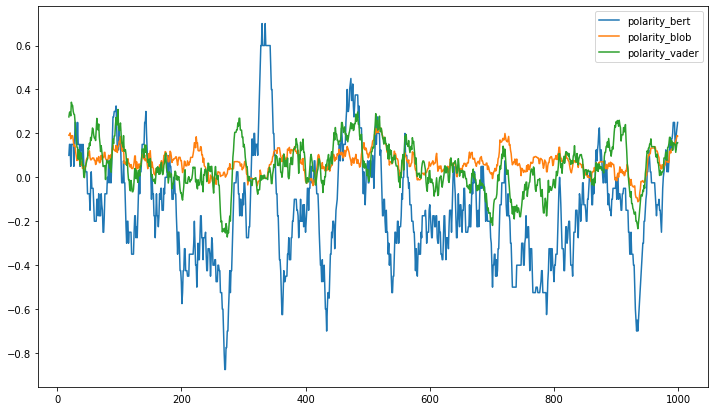

In [23]:
df.polarity_bert.rolling(20).mean().plot(legend=True, figsize=(12,7));
df.polarity_blob.rolling(20).mean().plot(legend=True, figsize=(12,7));
df.polarity_vader.rolling(20).mean().plot(legend=True, figsize=(12,7));

In [24]:
df.describe()

,polarity_blob,polarity_vader,subjectivity,polarity_bert
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.070047,0.052417,0.308137,-0.133000
std,0.239378,0.422281,0.279236,0.909471
min,-1.000000,-0.974300,0.000000,-1.000000
25%,0.000000,-0.202300,0.000000,-1.000000
50%,0.000000,0.000000,0.300000,-0.500000
75%,0.166667,0.401900,0.509643,1.000000
max,1.000000,0.953100,1.000000,1.000000


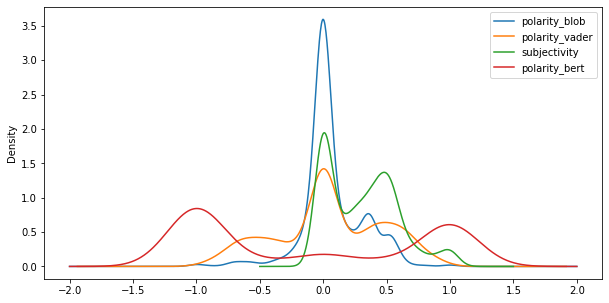

In [25]:
df.plot(figsize=(10,5), kind='density', legend=True);